<a href="https://colab.research.google.com/github/PeterTKovacs/mosquito_recoginition/blob/main/APRO_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import os

import numpy as np
import torch
import torchvision

from torchvision import transforms
from tqdm import tqdm

In [34]:
class BaseLine:
    def __init__(self):
        import torch
        import torchvision
        self.input_images_path = 'drive/My Drive/AML2020/images'
        self.csv = 'drive/My Drive/AML2020/train.csv'
        
        self.input_path = 'drive/My Drive/AML2020'
        self.train_path = 'drive/My Drive/AML2020/train'
        self.test_path = 'drive/My Drive/AML2020/test'
        self.valid_path = 'drive/My Drive/AML2020/validation'

    
    def folder_generator(self):
        import pandas as pd
        import logging as log
        import os
        
        csv_labels = pd.read_csv(self.csv)
        
        images_paths = list(csv_labels['file'])
        images_paths = [path.replace('images/', '') for path in images_paths]
        
        images_labels = list(csv_labels['is_tiger'])
        counter = 1
        
        tiger_path_train = os.path.join(self.train_path, 'tiger')
        not_tiger_path_train = os.path.join(self.train_path, 'not_tiger')
        
        tiger_path_val = os.path.join(self.valid_path, 'tiger')
        not_tiger_path_val = os.path.join(self.valid_path, 'not_tiger')
        
        test_unknown_path = os.path.join(self.test_path, 'unknown')
        
        os.mkdir(self.train_path)
        os.mkdir(tiger_path_train)
        os.mkdir(not_tiger_path_train)

        os.mkdir(self.valid_path)
        os.mkdir(tiger_path_val)
        os.mkdir(not_tiger_path_val)
        
        os.mkdir(self.test_path)
        os.mkdir(test_unknown_path)
        
        #Handling Train Images
        print('###Handling Train Images')
        for image_name, image_label in zip(images_paths, images_labels):
            print('Copying image: {}, with label: {}'.format(image_name, image_label))    
            if image_name.split('_')[0] == 'train' and counter % 5 != 0:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_train))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_train))
            else:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_val))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_val))
            
        #Handling Test Images
        #print('###Handling Test Images')
        #list_of_images = os.listdir(self.input_images_path)
        #for image_name in list_of_images:
            #if image_name.split('_')[0] == 'test':
        #        source_dir = os.path.join(self.input_images_path, image_name) 
        #        dest_dir = os.path.join(test_unknown_path, image_name)
         #       shutil.copy(source_dir, dest_dir)
          #      print('Copied image: {} to {}'.format(image_name, test_unknown_path))
           #           
        #print('Number of All train images: {}'.format(len(os.listdir(tiger_path_train)) + len(os.listdir(not_tiger_path_train))))
        #print('Number of All validation images: {}'.format(len(os.listdir(tiger_path_val)) + len(os.listdir(not_tiger_path_val))))
        
        #print('Number of All test images: {}'.format(len(os.listdir(self.test_path))))
        
        #print('Tiger Labels: {}'.format(len([label for label in images_labels if label == 1])))
        #print('NotTiger Labels: {}'.format(len([label for label in images_labels if label != 1])))
    
    def data_loader(self):
        import torch
        import torchvision
        from torchvision import transforms
        #ImageFolder
        #Augementation for train and valid images
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=3),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_dataset = torchvision.datasets.ImageFolder(self.train_path, train_transforms)
        validation_dataset = torchvision.datasets.ImageFolder(self.valid_path, val_transforms)
        
        #DataLoader
        batch_size = 16
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )
        print(len(train_dataset), len(validation_dataset))
        print(len(train_dataloader), len(validation_dataloader))
        return train_dataloader, validation_dataloader
    
    def show_images(self, train_dataloader):
        import numpy as np
        import matplotlib.pyplot as plt
        X_batch, y_batch = next(iter(train_dataloader))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        for index in range(5):
            plt.title(y_batch[index])
            plt.imshow(X_batch[index].permute(1,2,0).numpy() * std + mean, )
            plt.show()
    
    def model(self):
        from torchvision import models
        import torch
        model = models.resnet152(pretrained=False)
        
        #Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False 

        model.fc = torch.nn.Linear(model.fc.in_features, 2)
        #model.fc = self.sigmoid = ()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=1.0e-3)
       
        
        #Declay LR by a factor of 0.1 every 5th epoch
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
        return model, loss, optimizer, scheduler, device
    
    def train_model(self, model, loss, optimizer, scheduler, train, validation, device, num_epochs):
        import torch
        from tqdm import tqdm
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train
                    scheduler.step()
                    
                    model.train()  # Set model to training mode
                else:
                    dataloader = validation
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.
                running_acc = 0.

                # Iterate over data.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

        return model

    
    def run(self):
        #Processing data
        Job = BaseLine()
        #Job.folder_generator()
        train_dataloader, validation_dataloader = Job.data_loader()
        Job.show_images(train_dataloader)
        
        #Define model
        model, loss, optimizer, scheduler, device = Job.model()
        #print(model, loss, optimizer, scheduler)
        #Train model 
        trained_model = Job.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader, device, num_epochs=7)
        return trained_model

3424 855
214 54


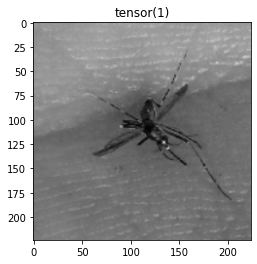

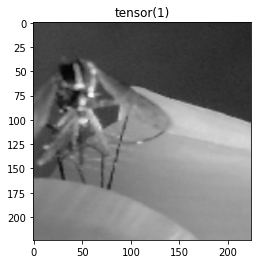

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


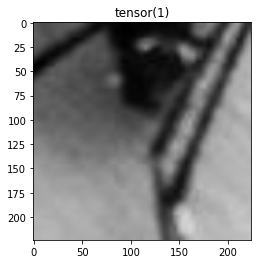

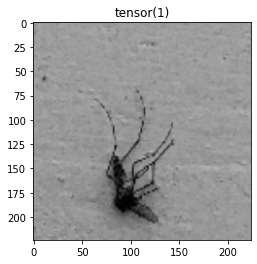

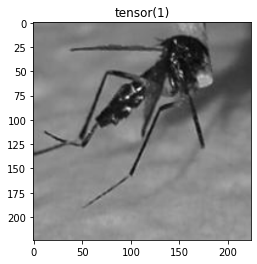

Epoch 0/6:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:02<07:36,  2.14s/it]


  1%|          | 2/214 [00:02<05:43,  1.62s/it]


  1%|▏         | 3/214 [00:02<04:18,  1.23s/it]


  2%|▏         | 4/214 [00:03<03:09,  1.11it/s]


  2%|▏         | 5/214 [00:03<02:25,  1.43it/s]


  3%|▎         | 6/214 [00:03<01:50,  1.87it/s]


  3%|▎         | 7/214 [00:03<01:28,  2.35it/s]


  4%|▎         | 8/214 [00:03<01:12,  2.86it/s]


  4%

train Loss: 0.4906 Acc: 0.8312






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:09<08:17,  9.39s/it]


  4%|▎         | 2/54 [00:09<05:44,  6.62s/it]


  6%|▌         | 3/54 [00:09<03:58,  4.67s/it]


  7%|▋         | 4/54 [00:09<02:45,  3.31s/it]


  9%|▉         | 5/54 [00:12<02:27,  3.01s/it]


 11%|█         | 6/54 [00:12<01:43,  2.15s/it]


 13%|█▎        | 7/54 [00:12<01:12,  1.55s/it]


 15%|█▍        | 8/54 [00:12<00:51,  1.12s/it]


 17%|█▋        | 9/54 [00:12<00:36,  1.22it/s]


 19%|█▊        | 10/54 [00:12<00:27,  1.63it/s]


 20%|██        | 11/54 [00:12<00:20,  2.14it/s]


 22%|██▏       | 12/54 [00:13<00:15,  2.74it/s]


 24%|██▍       | 13/54 [00:13<00:12,  3.38it/s]


 26%|██▌       | 14/54 [00:13<00:09,  4.08it/s]


 28%|██▊       | 15/54 [00:13<00:08,  4.76it/s]


 30%|██▉       | 16/54 [00:13<00:07,  5.38it/s]


 31%|███▏      | 17/54 [00:18<00:55,  1.51s/it]


 33%|███▎      | 18/54 [00:18<00:39,  1.09s/it]


 35%|███▌      | 19/54 [00:18<00:28,  1.25it/s]


 37%|███▋     

val Loss: 0.4736 Acc: 0.8426
Epoch 1/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:02<07:32,  2.12s/it]


  1%|          | 2/214 [00:02<05:43,  1.62s/it]


  1%|▏         | 3/214 [00:02<04:23,  1.25s/it]


  2%|▏         | 4/214 [00:03<03:22,  1.04it/s]


  2%|▏         | 5/214 [00:03<02:30,  1.39it/s]


  3%|▎         | 6/214 [00:03<01:52,  1.84it/s]


  3%|▎         | 7/214 [00:03<01:27,  2.37it/s]


  4%|▎         | 8/214 [00:03<01:09,  2.98it/s]


  4%|▍         | 9/214 [00:03<00:57,  3.58it/s]


  5%|▍         | 10/214 [00:04<00:48,  4.21it/s]


  5%|▌         | 11/214 [00:04<00:41,  4.85it/s]


  6%|▌         | 12/214 [00:04<00:37,  5.38it/s]


  6%|▌         | 13/214 [00:04<00:34,  5.87it/s]


  7%|▋         | 14/214 [00:04<00:32,  6.18it/s]


  7%|▋         | 15/214 [00:04<00:30,  6.43it/s]


  7%|▋         | 16/214 [00:04<00:29,  6.69it/s]


  8%|▊         | 17/214 [00:05<00:28,  6.81it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.89it/s]


  9%|▉         | 19/214 [00:05<00:27,  7.08it

train Loss: 0.4913 Acc: 0.8318






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:01<01:38,  1.86s/it]


  4%|▎         | 2/54 [00:02<01:14,  1.44s/it]


  6%|▌         | 3/54 [00:02<00:56,  1.11s/it]


  7%|▋         | 4/54 [00:02<00:43,  1.15it/s]


  9%|▉         | 5/54 [00:03<00:32,  1.52it/s]


 11%|█         | 6/54 [00:03<00:24,  1.99it/s]


 13%|█▎        | 7/54 [00:03<00:18,  2.56it/s]


 15%|█▍        | 8/54 [00:03<00:14,  3.16it/s]


 17%|█▋        | 9/54 [00:03<00:11,  3.83it/s]


 19%|█▊        | 10/54 [00:03<00:09,  4.49it/s]


 20%|██        | 11/54 [00:03<00:08,  5.16it/s]


 22%|██▏       | 12/54 [00:04<00:07,  5.67it/s]


 24%|██▍       | 13/54 [00:04<00:06,  6.17it/s]


 26%|██▌       | 14/54 [00:04<00:06,  6.51it/s]


 28%|██▊       | 15/54 [00:04<00:05,  6.81it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.99it/s]


 31%|███▏      | 17/54 [00:04<00:05,  7.10it/s]


 33%|███▎      | 18/54 [00:04<00:05,  7.18it/s]


 35%|███▌      | 19/54 [00:05<00:04,  7.26it/s]


 37%|███▋     

val Loss: 2.0148 Acc: 0.8381
Epoch 2/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:01<06:22,  1.79s/it]


  1%|          | 2/214 [00:02<04:56,  1.40s/it]


  1%|▏         | 3/214 [00:02<03:53,  1.11s/it]


  2%|▏         | 4/214 [00:02<02:53,  1.21it/s]


  2%|▏         | 5/214 [00:03<02:27,  1.42it/s]


  3%|▎         | 6/214 [00:03<01:56,  1.79it/s]


  3%|▎         | 7/214 [00:03<01:30,  2.28it/s]


  4%|▎         | 8/214 [00:03<01:12,  2.86it/s]


  4%|▍         | 9/214 [00:03<00:58,  3.48it/s]


  5%|▍         | 10/214 [00:04<00:49,  4.12it/s]


  5%|▌         | 11/214 [00:04<00:43,  4.72it/s]


  6%|▌         | 12/214 [00:04<00:38,  5.27it/s]


  6%|▌         | 13/214 [00:04<00:35,  5.73it/s]


  7%|▋         | 14/214 [00:04<00:33,  6.06it/s]


  7%|▋         | 15/214 [00:04<00:31,  6.33it/s]


  7%|▋         | 16/214 [00:04<00:29,  6.67it/s]


  8%|▊         | 17/214 [00:05<00:28,  6.85it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.92it/s]


  9%|▉         | 19/214 [00:05<00:28,  6.94it

train Loss: 0.5090 Acc: 0.8309






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:01<01:43,  1.96s/it]


  4%|▎         | 2/54 [00:02<01:15,  1.46s/it]


  6%|▌         | 3/54 [00:02<00:54,  1.07s/it]


  7%|▋         | 4/54 [00:02<00:39,  1.25it/s]


  9%|▉         | 5/54 [00:02<00:29,  1.64it/s]


 11%|█         | 6/54 [00:03<00:25,  1.85it/s]


 13%|█▎        | 7/54 [00:03<00:20,  2.27it/s]


 15%|█▍        | 8/54 [00:03<00:16,  2.85it/s]


 17%|█▋        | 9/54 [00:03<00:12,  3.47it/s]


 19%|█▊        | 10/54 [00:03<00:10,  4.10it/s]


 20%|██        | 11/54 [00:03<00:09,  4.74it/s]


 22%|██▏       | 12/54 [00:04<00:07,  5.38it/s]


 24%|██▍       | 13/54 [00:04<00:06,  5.94it/s]


 26%|██▌       | 14/54 [00:04<00:06,  6.31it/s]


 28%|██▊       | 15/54 [00:04<00:05,  6.68it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.90it/s]


 31%|███▏      | 17/54 [00:04<00:05,  7.02it/s]


 33%|███▎      | 18/54 [00:04<00:05,  6.99it/s]


 35%|███▌      | 19/54 [00:04<00:04,  7.25it/s]


 37%|███▋     

val Loss: 0.4850 Acc: 0.8426
Epoch 3/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:02<07:56,  2.24s/it]


  1%|          | 2/214 [00:02<05:46,  1.64s/it]


  1%|▏         | 3/214 [00:02<04:31,  1.29s/it]


  2%|▏         | 4/214 [00:03<03:25,  1.02it/s]


  2%|▏         | 5/214 [00:03<02:33,  1.36it/s]


  3%|▎         | 6/214 [00:03<01:56,  1.78it/s]


  3%|▎         | 7/214 [00:03<01:31,  2.27it/s]


  4%|▎         | 8/214 [00:03<01:11,  2.87it/s]


  4%|▍         | 9/214 [00:03<00:58,  3.52it/s]


  5%|▍         | 10/214 [00:04<00:49,  4.16it/s]


  5%|▌         | 11/214 [00:04<00:42,  4.76it/s]


  6%|▌         | 12/214 [00:04<00:38,  5.27it/s]


  6%|▌         | 13/214 [00:04<00:35,  5.74it/s]


  7%|▋         | 14/214 [00:04<00:32,  6.14it/s]


  7%|▋         | 15/214 [00:04<00:30,  6.51it/s]


  7%|▋         | 16/214 [00:04<00:29,  6.63it/s]


  8%|▊         | 17/214 [00:05<00:28,  6.88it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.94it/s]


  9%|▉         | 19/214 [00:05<00:27,  7.13it

train Loss: 0.5004 Acc: 0.8265






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:02<01:51,  2.11s/it]


  4%|▎         | 2/54 [00:02<01:19,  1.53s/it]


  6%|▌         | 3/54 [00:02<00:57,  1.12s/it]


  7%|▋         | 4/54 [00:02<00:41,  1.20it/s]


  9%|▉         | 5/54 [00:02<00:31,  1.53it/s]


 11%|█         | 6/54 [00:03<00:25,  1.89it/s]


 13%|█▎        | 7/54 [00:03<00:20,  2.31it/s]


 15%|█▍        | 8/54 [00:03<00:16,  2.81it/s]


 17%|█▋        | 9/54 [00:03<00:13,  3.45it/s]


 19%|█▊        | 10/54 [00:03<00:10,  4.12it/s]


 20%|██        | 11/54 [00:03<00:08,  4.78it/s]


 22%|██▏       | 12/54 [00:03<00:07,  5.35it/s]


 24%|██▍       | 13/54 [00:04<00:07,  5.85it/s]


 26%|██▌       | 14/54 [00:04<00:06,  6.23it/s]


 28%|██▊       | 15/54 [00:04<00:05,  6.51it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.84it/s]


 31%|███▏      | 17/54 [00:04<00:05,  6.84it/s]


 33%|███▎      | 18/54 [00:04<00:05,  7.12it/s]


 35%|███▌      | 19/54 [00:04<00:04,  7.29it/s]


 37%|███▋     

val Loss: 1.4992 Acc: 0.8396
Epoch 4/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:01<06:59,  1.97s/it]


  1%|          | 2/214 [00:02<05:08,  1.46s/it]


  1%|▏         | 3/214 [00:02<03:46,  1.07s/it]


  2%|▏         | 4/214 [00:02<02:56,  1.19it/s]


  2%|▏         | 5/214 [00:03<02:27,  1.42it/s]


  3%|▎         | 6/214 [00:03<02:03,  1.68it/s]


  3%|▎         | 7/214 [00:03<01:41,  2.05it/s]


  4%|▎         | 8/214 [00:03<01:19,  2.59it/s]


  4%|▍         | 9/214 [00:03<01:04,  3.20it/s]


  5%|▍         | 10/214 [00:04<00:52,  3.86it/s]


  5%|▌         | 11/214 [00:04<00:45,  4.51it/s]


  6%|▌         | 12/214 [00:04<00:39,  5.11it/s]


  6%|▌         | 13/214 [00:04<00:35,  5.61it/s]


  7%|▋         | 14/214 [00:04<00:32,  6.07it/s]


  7%|▋         | 15/214 [00:04<00:31,  6.27it/s]


  7%|▋         | 16/214 [00:04<00:30,  6.59it/s]


  8%|▊         | 17/214 [00:05<00:29,  6.67it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.78it/s]


  9%|▉         | 19/214 [00:05<00:28,  6.82it

train Loss: 0.4481 Acc: 0.8364






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:01<01:45,  1.99s/it]


  4%|▎         | 2/54 [00:02<01:15,  1.45s/it]


  6%|▌         | 3/54 [00:02<00:54,  1.07s/it]


  7%|▋         | 4/54 [00:02<00:40,  1.25it/s]


  9%|▉         | 5/54 [00:02<00:30,  1.62it/s]


 11%|█         | 6/54 [00:02<00:23,  2.07it/s]


 13%|█▎        | 7/54 [00:03<00:18,  2.55it/s]


 15%|█▍        | 8/54 [00:03<00:16,  2.74it/s]


 17%|█▋        | 9/54 [00:03<00:13,  3.22it/s]


 19%|█▊        | 10/54 [00:03<00:11,  3.87it/s]


 20%|██        | 11/54 [00:03<00:09,  4.55it/s]


 22%|██▏       | 12/54 [00:03<00:08,  5.17it/s]


 24%|██▍       | 13/54 [00:04<00:07,  5.72it/s]


 26%|██▌       | 14/54 [00:04<00:06,  6.21it/s]


 28%|██▊       | 15/54 [00:04<00:05,  6.60it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.93it/s]


 31%|███▏      | 17/54 [00:04<00:05,  7.04it/s]


 33%|███▎      | 18/54 [00:04<00:04,  7.21it/s]


 35%|███▌      | 19/54 [00:04<00:04,  7.27it/s]


 37%|███▋     

val Loss: 0.4633 Acc: 0.8411
Epoch 5/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:01<06:16,  1.77s/it]


  1%|          | 2/214 [00:02<05:09,  1.46s/it]


  1%|▏         | 3/214 [00:02<04:02,  1.15s/it]


  2%|▏         | 4/214 [00:03<03:08,  1.12it/s]


  2%|▏         | 5/214 [00:03<02:19,  1.50it/s]


  3%|▎         | 6/214 [00:03<01:46,  1.95it/s]


  3%|▎         | 7/214 [00:03<01:23,  2.49it/s]


  4%|▎         | 8/214 [00:03<01:06,  3.09it/s]


  4%|▍         | 9/214 [00:03<00:55,  3.69it/s]


  5%|▍         | 10/214 [00:04<00:47,  4.32it/s]


  5%|▌         | 11/214 [00:04<00:40,  4.96it/s]


  6%|▌         | 12/214 [00:04<00:37,  5.46it/s]


  6%|▌         | 13/214 [00:04<00:33,  5.96it/s]


  7%|▋         | 14/214 [00:04<00:32,  6.22it/s]


  7%|▋         | 15/214 [00:04<00:30,  6.45it/s]


  7%|▋         | 16/214 [00:04<00:29,  6.63it/s]


  8%|▊         | 17/214 [00:05<00:28,  6.88it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.99it/s]


  9%|▉         | 19/214 [00:05<00:27,  7.03it

train Loss: 0.4358 Acc: 0.8364






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:01<01:35,  1.80s/it]


  4%|▎         | 2/54 [00:01<01:08,  1.32s/it]


  6%|▌         | 3/54 [00:02<00:50,  1.01it/s]


  7%|▋         | 4/54 [00:02<00:37,  1.35it/s]


  9%|▉         | 5/54 [00:02<00:27,  1.75it/s]


 11%|█         | 6/54 [00:02<00:21,  2.19it/s]


 13%|█▎        | 7/54 [00:02<00:17,  2.66it/s]


 15%|█▍        | 8/54 [00:03<00:15,  3.00it/s]


 17%|█▋        | 9/54 [00:03<00:13,  3.31it/s]


 19%|█▊        | 10/54 [00:03<00:12,  3.51it/s]


 20%|██        | 11/54 [00:03<00:10,  3.92it/s]


 22%|██▏       | 12/54 [00:03<00:09,  4.54it/s]


 24%|██▍       | 13/54 [00:04<00:07,  5.19it/s]


 26%|██▌       | 14/54 [00:04<00:06,  5.77it/s]


 28%|██▊       | 15/54 [00:04<00:06,  6.16it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.59it/s]


 31%|███▏      | 17/54 [00:04<00:05,  6.82it/s]


 33%|███▎      | 18/54 [00:04<00:05,  6.92it/s]


 35%|███▌      | 19/54 [00:04<00:04,  7.03it/s]


 37%|███▋     

val Loss: 0.4650 Acc: 0.8196
Epoch 6/6:






  0%|          | 0/214 [00:00<?, ?it/s]


  0%|          | 1/214 [00:02<07:59,  2.25s/it]


  1%|          | 2/214 [00:02<05:52,  1.66s/it]


  1%|▏         | 3/214 [00:02<04:14,  1.21s/it]


  2%|▏         | 4/214 [00:03<03:23,  1.03it/s]


  2%|▏         | 5/214 [00:03<02:37,  1.32it/s]


  3%|▎         | 6/214 [00:03<01:59,  1.74it/s]


  3%|▎         | 7/214 [00:03<01:32,  2.24it/s]


  4%|▎         | 8/214 [00:03<01:12,  2.84it/s]


  4%|▍         | 9/214 [00:03<00:59,  3.44it/s]


  5%|▍         | 10/214 [00:04<00:50,  4.05it/s]


  5%|▌         | 11/214 [00:04<00:43,  4.69it/s]


  6%|▌         | 12/214 [00:04<00:38,  5.23it/s]


  6%|▌         | 13/214 [00:04<00:34,  5.75it/s]


  7%|▋         | 14/214 [00:04<00:32,  6.07it/s]


  7%|▋         | 15/214 [00:04<00:30,  6.46it/s]


  7%|▋         | 16/214 [00:04<00:29,  6.69it/s]


  8%|▊         | 17/214 [00:05<00:28,  6.84it/s]


  8%|▊         | 18/214 [00:05<00:28,  6.96it/s]


  9%|▉         | 19/214 [00:05<00:27,  6.99it

train Loss: 0.4414 Acc: 0.8359






  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:02<01:48,  2.05s/it]


  4%|▎         | 2/54 [00:02<01:17,  1.50s/it]


  6%|▌         | 3/54 [00:02<00:55,  1.09s/it]


  7%|▋         | 4/54 [00:02<00:41,  1.22it/s]


  9%|▉         | 5/54 [00:02<00:30,  1.62it/s]


 11%|█         | 6/54 [00:03<00:25,  1.85it/s]


 13%|█▎        | 7/54 [00:03<00:20,  2.29it/s]


 15%|█▍        | 8/54 [00:03<00:16,  2.84it/s]


 17%|█▋        | 9/54 [00:03<00:12,  3.48it/s]


 19%|█▊        | 10/54 [00:03<00:10,  4.17it/s]


 20%|██        | 11/54 [00:03<00:08,  4.84it/s]


 22%|██▏       | 12/54 [00:03<00:07,  5.36it/s]


 24%|██▍       | 13/54 [00:04<00:07,  5.86it/s]


 26%|██▌       | 14/54 [00:04<00:06,  6.18it/s]


 28%|██▊       | 15/54 [00:04<00:05,  6.51it/s]


 30%|██▉       | 16/54 [00:04<00:05,  6.82it/s]


 31%|███▏      | 17/54 [00:04<00:05,  7.03it/s]


 33%|███▎      | 18/54 [00:04<00:04,  7.20it/s]


 35%|███▌      | 19/54 [00:04<00:04,  7.27it/s]


 37%|███▋     

val Loss: 0.6740 Acc: 0.8396


In [35]:
model = BaseLine().run()

In [ ]:
torch.save(model, 'drive/My Drive/AML2020/model')